In [160]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

### Carga de Datos

In [161]:
def load_data(file_path):
    return pd.read_csv(file_path, encoding='utf-8')

In [162]:
clima_data = load_data(r"Datasets_limpios\NYCClima.csv")
tarifa_data= load_data(r'Datasets_limpios\taxis_tarifa.csv')

### Transformación de Datos

In [163]:
clima_data['time'] = pd.to_datetime(clima_data['time']) # Convierto la columna 'time' a formato de fecha

df_clima_grouped = clima_data.groupby(clima_data['time'].dt.date).agg({'temperature_2m (°C)': 'mean'}).reset_index() # Agrupo los datos por día y calculo el promedio de temperaturas por día
 
df_clima_grouped.rename(columns={'time': 'date', 'temperature_2m (°C)': 'avg_temperature'}, inplace=True) # Renombro las columnas para mayor claridad

print(df_clima_grouped)

           date  avg_temperature
0    2021-01-01         0.841667
1    2021-01-02         6.104167
2    2021-01-03         1.287500
3    2021-01-04         2.350000
4    2021-01-05         2.479167
..          ...              ...
947  2023-08-06        23.366667
948  2023-08-07        23.620833
949  2023-08-08        23.608333
950  2023-08-09        23.416667
951  2023-08-10        22.208333

[952 rows x 2 columns]


In [164]:
tarifa_data['Fecha'] = pd.to_datetime(tarifa_data['Fecha']) # Convierto la columna 'Fecha' a formato de fecha

dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'] # Lista de nombres de días de la semana en español

tarifa_data['DiaSemana'] = tarifa_data['Fecha'].dt.dayofweek.map(lambda x: dias_semana[x]) # Agrego una columna con el día de la semana en español  

tarifa_grouped = tarifa_data.groupby(tarifa_data['Fecha'].dt.date).agg({ # Agrupo los datos por día y sumo las cantidades de pasajeros y viajes por día
    'Pasajeros por dia': 'sum',
    'Viajes por dia': 'sum',
    'Tipo de Taxi': 'first',
    'DiaSemana': 'first'
}).reset_index()

print(tarifa_grouped)

          Fecha  Pasajeros por dia  Viajes por dia Tipo de Taxi  DiaSemana
0    2022-01-01              97692           64714        green     Sábado
1    2022-01-02              87866           59921        green    Domingo
2    2022-01-03             102660           74737        green      Lunes
3    2022-01-04             103558           76727        green     Martes
4    2022-01-05             102768           76851        green  Miércoles
..          ...                ...             ...          ...        ...
483  2023-04-29             154698          112432        green     Sábado
484  2023-04-30             130105           95981        green    Domingo
485  2023-05-01                  1               1       yellow      Lunes
486  2023-05-02                 29              23       yellow     Martes
487  2023-05-03                 29              22       yellow  Miércoles

[488 rows x 5 columns]


In [165]:
tabla_combinada = pd.merge(tarifa_grouped, df_clima_grouped, left_on='Fecha', right_on='date', how='inner') # Uno las dos tablas por la columna 'Fecha'

tabla_combinada.drop(columns=['date'], inplace=True)
tabla_combinada.drop(columns=['Fecha'], inplace=True)# Elimino la columna 'date' 

print(tabla_combinada)

     Pasajeros por dia  Viajes por dia Tipo de Taxi  DiaSemana  \
0                97692           64714        green     Sábado   
1                87866           59921        green    Domingo   
2               102660           74737        green      Lunes   
3               103558           76727        green     Martes   
4               102768           76851        green  Miércoles   
..                 ...             ...          ...        ...   
483             154698          112432        green     Sábado   
484             130105           95981        green    Domingo   
485                  1               1       yellow      Lunes   
486                 29              23       yellow     Martes   
487                 29              22       yellow  Miércoles   

     avg_temperature  
0           9.766667  
1          10.425000  
2           0.770833  
3          -2.920833  
4           0.712500  
..               ...  
483         9.770833  
484        12.004167  


In [166]:
X = tabla_combinada[['avg_temperature', 'DiaSemana', 'Tipo de Taxi', 'Pasajeros por dia']]# Divido los datos en características (X) y etiquetas (y)
y = tabla_combinada['Viajes por dia']

X['Tipo de Taxi_green'] = 0# Agrego columna 'Tipo de Taxi_green' con valor 0 en todas las filas

X.loc[X['Tipo de Taxi'] == 'green', 'Tipo de Taxi_green'] = 1# Modifico las filas donde el valor de 'Tipo de Taxi' es 'green' a 1

X['Tipo de Taxi_yellow'] = 0#Idem que para green

X.loc[X['Tipo de Taxi'] == 'yellow', 'Tipo de Taxi_yellow'] = 1#Idem que para green

X.drop(columns=['Tipo de Taxi'], inplace=True)# Elimino columna 'Tipo de Taxi'

X = pd.get_dummies(X, columns=['DiaSemana'], drop_first=True)# Convierto variables categóricas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# Divido los datos


In [167]:
X.head()

,avg_temperature,Pasajeros por dia,Tipo de Taxi_green,Tipo de Taxi_yellow,DiaSemana_Jueves,DiaSemana_Lunes,DiaSemana_Martes,DiaSemana_Miércoles,DiaSemana_Sábado,DiaSemana_Viernes
0,9.766667,97692,1,0,0,0,0,0,1,0
1,10.425000,87866,1,0,0,0,0,0,0,0
2,0.770833,102660,1,0,0,1,0,0,0,0
3,-2.920833,103558,1,0,0,0,1,0,0,0
4,0.712500,102768,1,0,0,0,0,1,0,0


### Creación de Modelo Random Forest

In [168]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [169]:
y_pred = model.predict(X_test)#Realizo predicciones

mse = mean_squared_error(y_test, y_pred)#Calculo error
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)#Calculo R cuadrado
print("R-squared:", r2)

Mean Squared Error: 10230435.314819388
R-squared: 0.9704697517283457


### Ajuste y Optimización

In [170]:
X = tabla_combinada.drop('Viajes por dia', axis=1)#Divido los datos
y = tabla_combinada['Viajes por dia']

X['Tipo de Taxi_green'] = 0

X.loc[X['Tipo de Taxi'] == 'green', 'Tipo de Taxi_green'] = 1

X['Tipo de Taxi_yellow'] = 0

X.loc[X['Tipo de Taxi'] == 'yellow', 'Tipo de Taxi_yellow'] = 1

X.drop(columns=['Tipo de Taxi'], inplace=True)

X = pd.get_dummies(X, columns=['DiaSemana'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Defino los parámetros a ajustar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


In [171]:
#Modelo
model = RandomForestRegressor(random_state=42)

In [172]:
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')# Realizo búsqueda en cuadrícula con validación cruzada
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_# Mejores parámetros encontrados
print("Mejores parámetros:", best_params)

best_model = RandomForestRegressor(**best_params, random_state=42)# Entreno el modelo con los mejores parámetros
best_model.fit(X_train, y_train)


Mejores parámetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


RandomForestRegressor(max_depth=10, n_estimators=50, random_state=42)

In [173]:
y_pred = best_model.predict(X_test)# Realizo predicciones en el conjunto de prueba

mse = mean_squared_error(y_test, y_pred)# Calculo el error
print("Mean Squared Error:", mse)

r2 = r2_score(y_test, y_pred)#Calculo R cuadrado
print("R-squared:", r2)

Mean Squared Error: 10421703.150715342
R-squared: 0.9699176553114701


### Guardo el modelo

In [174]:
import joblib

model_filename = 'modelo_random_forest.joblib'
joblib.dump(best_model, model_filename)

['modelo_random_forest.joblib']

### Prueba del modelo

In [175]:
loaded_model = joblib.load(model_filename)# Cargo el modelo desde el archivo

y_pred_loaded = loaded_model.predict(X_test)

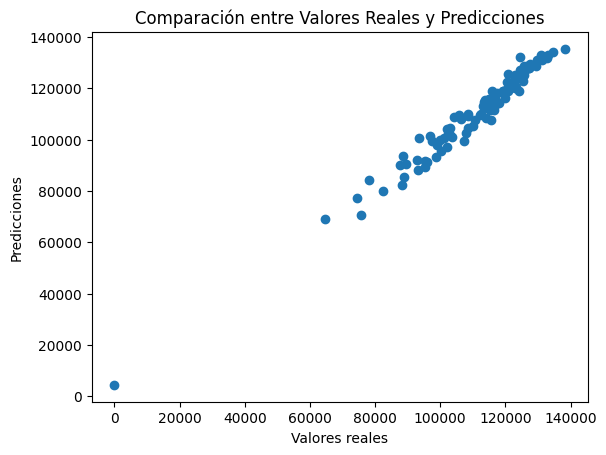

In [176]:
##Visualización de comparación entre valores reales y predicciones
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_loaded)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.show()


In [177]:
column_names_original = X_train.columns.tolist()
print("Orden de las columnas originales:", column_names_original)


Orden de las columnas originales: ['Pasajeros por dia', 'avg_temperature', 'Tipo de Taxi_green', 'Tipo de Taxi_yellow', 'DiaSemana_Jueves', 'DiaSemana_Lunes', 'DiaSemana_Martes', 'DiaSemana_Miércoles', 'DiaSemana_Sábado', 'DiaSemana_Viernes']


In [178]:
promedio_pasajeros = tabla_combinada['Pasajeros por dia'].mean()

column_names_original = ['Pasajeros por dia', 'avg_temperature', 'Tipo de Taxi_green', 'Tipo de Taxi_yellow',
                         'DiaSemana_Jueves', 'DiaSemana_Lunes', 'DiaSemana_Martes', 'DiaSemana_Miércoles',
                         'DiaSemana_Sábado', 'DiaSemana_Viernes']

nuevo_dato = pd.DataFrame({    # Creo un DataFrame nuevo_dato con las columnas reorganizadas
    'avg_temperature': [20.0],            
    'DiaSemana_Lunes': [0],               
    'DiaSemana_Martes': [0],             
    'DiaSemana_Miércoles': [1],           
    'DiaSemana_Jueves': [0],              
    'DiaSemana_Viernes': [0],            
    'DiaSemana_Sábado': [0],
    'Tipo de Taxi_green': [0],            
    'Tipo de Taxi_yellow': [1],           
    'Pasajeros por dia': [promedio_pasajeros]  
})

nuevo_dato = nuevo_dato[column_names_original] # Reorganizo las columnas de nuevo_dato para que coincidan con el orden original

prediccion = loaded_model.predict(nuevo_dato)

print("Predicción:", prediccion)



Predicción: [108460.65264579]
